# Emotion classification using the RAVDESS dataset

# Analysis

We are will first install LibROSA, a python package for music and audio analysis.

After the import, we will plot the signal of the first file.

In [1]:
!pip install librosa

In [2]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('../features/Actor_01/03-01-01-01-01-01-01.wav')

# Load all files

We will create our numpy array extracting Mel-frequency cepstral coefficients (MFCCs), while the classes to predict will be extracted from the name of the file (see the introductory section of this notebook to see the naming convention of the files of this dataset).

In [3]:
import time
import numpy as np
path = '../features/'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 652.7888643741608 seconds ---


In [4]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [5]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((2452, 40), (2452,))

# Decision Tree Classifier

To make a first attempt in accomplishing this classification task I chose a decision tree:

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [8]:
dtree = DecisionTreeClassifier()

In [9]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [10]:
predictions = dtree.predict(X_test)

Let's go with our classification report.

Before we start, a quick reminder of the classes we are trying to predict:

emotions = {
    "neutral": "0",
    "calm": "1",
    "happy": "2",
    "sad": "3",
    "angry": "4", 
    "fearful": "5", 
    "disgust": "6", 
    "surprised": "7"
}

In [11]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.40      0.46      0.43        57
           1       0.63      0.62      0.62       130
           2       0.52      0.48      0.50       126
           3       0.43      0.41      0.42       123
           4       0.55      0.59      0.57       122
           5       0.45      0.45      0.45       124
           6       0.31      0.27      0.29        63
           7       0.39      0.46      0.43        65

    accuracy                           0.48       810
   macro avg       0.46      0.47      0.46       810
weighted avg       0.48      0.48      0.48       810



# Random Forest

In this second approach, I switched to a random forest classifier and I made a gridsearch to make some hyperparameters tuning.

The gridsearch is not shown in the code below otherwise the notebook will require too much time to run.

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [14]:
rforest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='log2', max_leaf_nodes=100,
                       min_samples_leaf=3, min_samples_split=20,
                       n_estimators=22000, random_state=5)

In [15]:
predictions = rforest.predict(X_test)

In [16]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.93      0.44      0.60        57
           1       0.64      0.88      0.74       130
           2       0.72      0.51      0.60       126
           3       0.55      0.63      0.59       123
           4       0.68      0.77      0.72       122
           5       0.58      0.54      0.56       124
           6       0.47      0.30      0.37        63
           7       0.46      0.57      0.51        65

    accuracy                           0.62       810
   macro avg       0.63      0.58      0.59       810
weighted avg       0.63      0.62      0.61       810



# Neural network

Let's build our neural network!

To do so, we need to expand the dimensions of our array, adding a third one using the numpy "expand_dims" feature.

In [17]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [18]:
x_traincnn.shape, x_testcnn.shape

((1642, 40, 1), (810, 40, 1))

In [19]:
from tensorflow import keras
from keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


With *model.summary* we can see a recap of what we have build:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 128)           768       
_________________________________________________________________
activation (Activation)      (None, 40, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_1 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 128)            0

Now we can compile and fit our model:

In [21]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [22]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

Epoch 1/1000
103/103 [==============================] - 1s 4ms/step - loss: 7.8388 - accuracy: 0.1255 - val_loss: 2.7198 - val_accuracy: 0.1691
Epoch 2/1000
103/103 [==============================] - 0s 3ms/step - loss: 6.4381 - accuracy: 0.1431 - val_loss: 2.5544 - val_accuracy: 0.1840
Epoch 3/1000
103/103 [==============================] - 0s 3ms/step - loss: 5.7996 - accuracy: 0.1480 - val_loss: 2.2400 - val_accuracy: 0.2086
Epoch 4/1000
103/103 [==============================] - 0s 3ms/step - loss: 5.0753 - accuracy: 0.1486 - val_loss: 2.1103 - val_accuracy: 0.2210
Epoch 5/1000
103/103 [==============================] - 0s 3ms/step - loss: 4.4553 - accuracy: 0.1644 - val_loss: 2.3932 - val_accuracy: 0.1864
Epoch 6/1000
103/103 [==============================] - 0s 3ms/step - loss: 3.8973 - accuracy: 0.1815 - val_loss: 2.5567 - val_accuracy: 0.1827
Epoch 7/1000
103/103 [==============================] - 0s 3ms/step - loss: 3.4816 - accuracy: 0.1900 - val_loss: 2.0271 - val_accuracy:

Let's plot the loss:

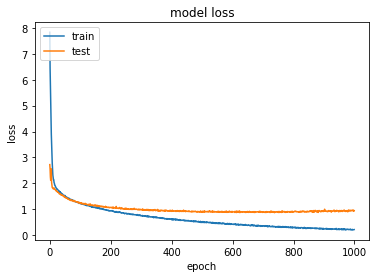

In [23]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



And now let's plot the accuracy:

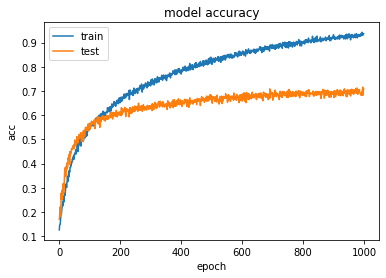

In [24]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Let's now create a classification report to review the f1-score of the model per class.
To do so, we have to:
- Create a variable predictions that will contain the model.predict_classes outcome
- Convert our y_test (array of strings with our classes) to an array of int called new_Ytest, otherwise it will not be comparable to the predictions by the classification report.

In [25]:
predictions = model.predict(x_testcnn)
predictions=np.argmax(predictions,axis=1)

In [26]:
predictions

array([2, 2, 3, 1, 1, 2, 1, 4, 4, 4, 3, 6, 7, 2, 1, 5, 4, 4, 5, 1, 7, 4,
       3, 1, 6, 7, 5, 6, 7, 7, 4, 5, 0, 7, 0, 4, 1, 3, 4, 1, 3, 3, 2, 1,
       2, 4, 5, 1, 6, 3, 6, 4, 6, 5, 2, 4, 5, 0, 5, 2, 1, 3, 5, 3, 3, 1,
       2, 4, 1, 3, 4, 0, 6, 5, 5, 1, 2, 0, 5, 3, 6, 3, 3, 1, 4, 7, 0, 4,
       5, 5, 1, 5, 4, 2, 2, 1, 1, 3, 4, 7, 6, 1, 1, 7, 1, 3, 7, 2, 3, 4,
       7, 5, 4, 5, 1, 1, 0, 1, 7, 1, 1, 1, 6, 0, 2, 2, 3, 2, 2, 3, 5, 0,
       6, 7, 0, 7, 3, 7, 7, 3, 3, 1, 3, 6, 4, 4, 5, 2, 2, 4, 6, 7, 3, 7,
       6, 5, 3, 4, 5, 4, 4, 1, 4, 5, 1, 1, 6, 0, 5, 1, 5, 2, 1, 5, 1, 5,
       1, 7, 7, 2, 3, 1, 1, 2, 3, 1, 1, 4, 7, 1, 3, 0, 5, 1, 0, 5, 1, 1,
       4, 6, 1, 4, 3, 3, 7, 4, 3, 1, 3, 4, 7, 3, 3, 3, 5, 0, 2, 1, 1, 6,
       6, 3, 5, 3, 4, 2, 1, 1, 2, 4, 3, 7, 5, 5, 2, 6, 6, 5, 6, 1, 3, 7,
       1, 2, 3, 0, 5, 5, 3, 3, 5, 5, 2, 4, 3, 4, 6, 2, 3, 0, 3, 5, 2, 3,
       1, 7, 1, 2, 7, 7, 1, 6, 6, 1, 1, 2, 0, 0, 2, 1, 4, 7, 3, 2, 6, 5,
       2, 3, 5, 0, 4, 0, 2, 1, 5, 6, 6, 5, 2, 4, 5,

In [27]:
y_test

array([2, 2, 3, 1, 1, 1, 1, 2, 4, 4, 0, 6, 5, 2, 1, 3, 2, 4, 5, 3, 6, 4,
       0, 1, 6, 4, 2, 6, 7, 7, 4, 5, 3, 7, 4, 4, 1, 3, 4, 3, 3, 5, 2, 2,
       7, 4, 5, 3, 6, 3, 1, 4, 6, 3, 1, 4, 5, 0, 5, 2, 1, 3, 5, 3, 1, 3,
       2, 4, 6, 3, 4, 2, 6, 5, 5, 2, 2, 0, 5, 3, 7, 3, 3, 1, 4, 4, 0, 4,
       3, 5, 1, 5, 4, 2, 2, 1, 3, 5, 4, 7, 6, 2, 1, 7, 3, 2, 7, 2, 3, 4,
       7, 4, 4, 5, 1, 1, 0, 1, 7, 1, 2, 1, 6, 0, 2, 2, 3, 2, 2, 3, 5, 0,
       4, 6, 0, 7, 3, 7, 7, 1, 5, 1, 2, 7, 4, 4, 5, 2, 2, 4, 6, 7, 7, 2,
       6, 5, 3, 6, 2, 4, 4, 1, 4, 4, 3, 1, 6, 0, 5, 1, 5, 2, 1, 5, 1, 2,
       1, 7, 2, 2, 6, 1, 2, 2, 1, 1, 1, 4, 7, 1, 3, 3, 5, 3, 0, 5, 1, 0,
       4, 1, 1, 4, 3, 3, 7, 4, 3, 1, 3, 4, 7, 0, 5, 3, 5, 0, 2, 1, 1, 2,
       6, 1, 5, 3, 4, 2, 3, 0, 2, 4, 3, 5, 5, 4, 2, 7, 4, 5, 3, 3, 0, 7,
       1, 5, 3, 0, 4, 3, 3, 3, 2, 5, 2, 4, 2, 4, 3, 2, 3, 0, 3, 4, 5, 3,
       1, 3, 1, 5, 2, 7, 1, 7, 4, 1, 1, 2, 0, 0, 2, 1, 4, 5, 5, 2, 6, 5,
       5, 3, 3, 0, 4, 0, 2, 1, 5, 6, 6, 5, 1, 4, 2,

In [28]:
new_Ytest = y_test.astype(int)

In [29]:
new_Ytest

array([2, 2, 3, 1, 1, 1, 1, 2, 4, 4, 0, 6, 5, 2, 1, 3, 2, 4, 5, 3, 6, 4,
       0, 1, 6, 4, 2, 6, 7, 7, 4, 5, 3, 7, 4, 4, 1, 3, 4, 3, 3, 5, 2, 2,
       7, 4, 5, 3, 6, 3, 1, 4, 6, 3, 1, 4, 5, 0, 5, 2, 1, 3, 5, 3, 1, 3,
       2, 4, 6, 3, 4, 2, 6, 5, 5, 2, 2, 0, 5, 3, 7, 3, 3, 1, 4, 4, 0, 4,
       3, 5, 1, 5, 4, 2, 2, 1, 3, 5, 4, 7, 6, 2, 1, 7, 3, 2, 7, 2, 3, 4,
       7, 4, 4, 5, 1, 1, 0, 1, 7, 1, 2, 1, 6, 0, 2, 2, 3, 2, 2, 3, 5, 0,
       4, 6, 0, 7, 3, 7, 7, 1, 5, 1, 2, 7, 4, 4, 5, 2, 2, 4, 6, 7, 7, 2,
       6, 5, 3, 6, 2, 4, 4, 1, 4, 4, 3, 1, 6, 0, 5, 1, 5, 2, 1, 5, 1, 2,
       1, 7, 2, 2, 6, 1, 2, 2, 1, 1, 1, 4, 7, 1, 3, 3, 5, 3, 0, 5, 1, 0,
       4, 1, 1, 4, 3, 3, 7, 4, 3, 1, 3, 4, 7, 0, 5, 3, 5, 0, 2, 1, 1, 2,
       6, 1, 5, 3, 4, 2, 3, 0, 2, 4, 3, 5, 5, 4, 2, 7, 4, 5, 3, 3, 0, 7,
       1, 5, 3, 0, 4, 3, 3, 3, 2, 5, 2, 4, 2, 4, 3, 2, 3, 0, 3, 4, 5, 3,
       1, 3, 1, 5, 2, 7, 1, 7, 4, 1, 1, 2, 0, 0, 2, 1, 4, 5, 5, 2, 6, 5,
       5, 3, 3, 0, 4, 0, 2, 1, 5, 6, 6, 5, 1, 4, 2,

Now, the confusion matrix: it will show us the misclassified samples

In [30]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[ 38   6   0   8   1   1   1   2]
 [  4 107   3   7   0   2   5   2]
 [  3   7  84   3   7  13   2   7]
 [  3  14   1  83   0  10   4   8]
 [  3   2   4   3  88  10   6   6]
 [  0   0   9  17   4  87   0   7]
 [  1   4   2   2   5   4  38   7]
 [  0   0   4   3   1   0   9  48]]


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70        57
           1       0.76      0.82      0.79       130
           2       0.79      0.67      0.72       126
           3       0.66      0.67      0.67       123
           4       0.83      0.72      0.77       122
           5       0.69      0.70      0.69       124
           6       0.58      0.60      0.59        63
           7       0.55      0.74      0.63        65

    accuracy                           0.71       810
   macro avg       0.70      0.70      0.70       810
weighted avg       0.72      0.71      0.71       810



# Save the model

In [32]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = '../model/'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at ../model/Emotion_Voice_Detection_Model.h5 
